# **Лутченкова Екатерина**

## **Итоговый проект DLS**
# Генерация изображений с помощью pix2pix

# Часть 1. Имплементация статьи по pix2pix

Задача состоит в том, чтобы повторить решение, предложенное в статье, написать модель и убедиться, что она работает корректно. Я выбрала задачу восстановления фасада здания по его меткам.

Сама статья находится [здесь](https://arxiv.org/pdf/1611.07004.pdf).

In [ ]:
!pip3 freeze > requirements.txt 

## Импорты библиотек

In [ ]:
import numpy as np
import pandas as pd

# Загрузка
import os
from torch.utils.data import DataLoader, Dataset
from glob import glob
from pathlib import Path
from PIL import Image

# Архиектура нейронной сети
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as tt

# Отображение изображений
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.2)
from torchvision.utils import make_grid
from IPython.display import clear_output
%matplotlib inline

from tqdm.notebook import tqdm
from torchsummary import summary
import re

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Загрузка и создание датасета

In [ ]:
!wget http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades.tar.gz
!tar -xvf facades.tar.gz

Приведем изображения к размеру 256*256 и нормализуем.

Часть кода для загрузки датасета взята [отсюда](https://colab.research.google.com/github/LibreCV/blog/blob/master/_notebooks/2021-02-13-Pix2Pix%20explained%20with%20code.ipynb?authuser=2). 

In [ ]:
path_train = "./facades/train/"
path_val = "./facades/val/"

class FacadesDataset(Dataset):
    def __init__(self, path):
        self.filenames = glob(str(Path(path) / "*"))
    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        transform=tt.Compose([
                tt.Resize(256),
                tt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                ])
        
        filename = self.filenames[idx]
        image = Image.open(filename)
        image = tt.functional.to_tensor(image)
        image_width = image.shape[2]

        real = image[:, :, : image_width // 2]
        real = transform(real)
        condition = image[:, :, image_width // 2 :]
        condition = transform(condition)

        return condition, real

In [ ]:
batch_size=1

In [ ]:
train_dataset = FacadesDataset(path_train)
trainloader_facade = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = FacadesDataset(path_val)
valloader_facade = DataLoader(val_dataset, batch_size=10, shuffle=False)

Количество изображений для обучения:

In [ ]:
len(trainloader_facade.dataset)

400

Количество изображений для валидации:

In [ ]:
len(valloader_facade.dataset)

100

Денормировка, чтобы отобразить изображения в исходном виде

In [ ]:
def denorm(img_tensors):
    return img_tensors * 0.5 + 0.5

Посмотрим на датасет:

In [ ]:
def show_images(images, nmax, title=None, figsize=(20, 15)):
    fig, ax = plt.subplots(figsize=figsize)
    if title:
        fig.suptitle(title)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=nmax).permute(1, 2, 0))

def show_batch(dl, nmax=8):
    for real, condition in dl:
        show_images(real, nmax)
        show_images(condition, nmax)
        break

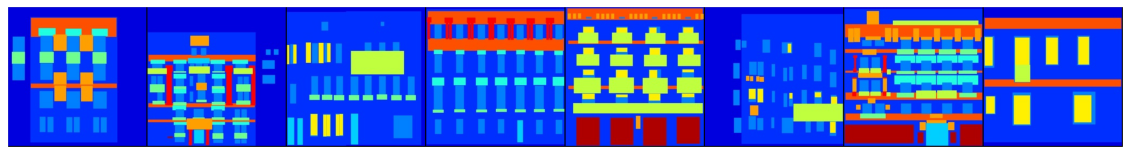

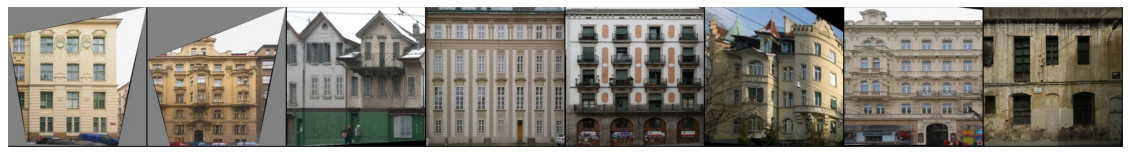

In [ ]:
show_batch(DataLoader(train_dataset, batch_size=8, shuffle=True))

Перенесем датасет на *cuda*: (код взят из одного из семинарских ноутбуков)

In [ ]:
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

In [ ]:
trainloader_facade = DeviceDataLoader(trainloader_facade, device)
valloader_facade = DeviceDataLoader(valloader_facade, device)

## Архитектура модели

Сеть состоит из двух основных частей: генератора и дискриминатора. Генератор преобразует входное изображение, чтобы получить выходное изображение. Дискриминатор измеряет сходство входного изображения с неизвестным изображением (либо целевое изображение из набора данных, либо выходное изображение из генератора) и пытается угадать, было ли оно создано генератором.

В качестве генератора используется архитектура U-Net, отличительной особенностью являются skip connections:

 ![alt text](https://machinelearningmastery.com/wp-content/uploads/2019/05/Architecture-of-the-U-Net-Generator-Model-1.png
 )

В качестве дискриминатора используется PatchGAN. Изображение делится на патчи, а дискриминатор предсказывает, является ли патч настоящим или фейковым, затем усредняет ответы.

 ![alt text](https://www.researchgate.net/profile/Gozde-Unal-2/publication/323904616/figure/fig1/AS:606457334595585@1521602104652/PatchGAN-discriminator-Each-value-of-the-output-matrix-represents-the-probability-of.png
 )

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()       
        
        # Энкодер

        self.conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride = 2, padding = 1),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride = 2, padding = 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride = 2, padding = 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride = 2, padding = 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=4, stride = 2, padding = 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=4, stride = 2, padding = 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.conv6 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=4, stride = 2, padding = 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.conv7 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=4, stride = 2, padding = 1),
            nn.LeakyReLU(0.2, inplace=True),
        )
      
        # Декодер
        
        self.deconv0 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=4, stride = 2, padding = 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.5)
        )      
        self.deconv1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=512*2, out_channels=512, kernel_size=4, stride = 2, padding = 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.5)
        ) 
        self.deconv2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=512*2, out_channels=512, kernel_size=4, stride = 2, padding = 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.5)
        )
        self.deconv3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=512*2, out_channels=512, kernel_size=4, stride = 2, padding = 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )    
        self.deconv4 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=512*2, out_channels=256, kernel_size=4, stride = 2, padding = 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True)
        )   
        self.deconv5 = nn.Sequential(    
            nn.ConvTranspose2d(in_channels=256*2, out_channels=128, kernel_size=4, stride =2, padding = 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.deconv6 = nn.Sequential( 
            nn.ConvTranspose2d(in_channels=128*2, out_channels=64, kernel_size=4, stride = 2, padding = 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.deconv7 = nn.Sequential( 
            nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=4, stride = 2, padding = 1)
        )

    def forward(self, x):
        e0 = self.conv0(x)
        e1 = self.conv1(e0)
        e2 = self.conv2(e1)
        e3 = self.conv3(e2)
        e4 = self.conv4(e3)
        e5 = self.conv5(e4)
        e6 = self.conv6(e5)
        e7 = self.conv7(e6)

        d0 = self.deconv0(e7)
        d1 = self.deconv1(torch.cat([e6,d0], dim=1))
        d2 = self.deconv2(torch.cat([e5,d1], dim=1))
        d3 = self.deconv3(torch.cat([e4,d2], dim=1))
        d4 = self.deconv4(torch.cat([e3,d3], dim=1))
        d5 = self.deconv5(torch.cat([e2,d4], dim=1))
        d6 = self.deconv6(torch.cat([e1,d5], dim=1))
        d7 = self.deconv7(d6)
        
        out = torch.tanh(d7)
        
        return out

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv0 = nn.Sequential(
            nn.Conv2d(in_channels=6, out_channels=64, kernel_size=4, stride = 2, padding = 1),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv1= nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride = 2, padding = 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride = 2, padding = 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride = 2, padding = 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1, kernel_size=4, stride = 1, padding = 1),
        )
    def forward(self, pred, real):
        x = torch.cat([pred, real], axis=1)
        x = self.conv0(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        # на выходе = сигмоида
        x = torch.sigmoid(x)

        return x

## Создание модели

In [ ]:
pix2pix = {
    "discriminator": Discriminator().to(device),
    "generator": Generator().to(device)
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.L1Loss()
}

Убедимся, что архитектура моделей написана правильно.

In [ ]:
summary(pix2pix['generator'], input_size=(3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           3,136
         LeakyReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3          [-1, 128, 64, 64]         131,200
       BatchNorm2d-4          [-1, 128, 64, 64]             256
         LeakyReLU-5          [-1, 128, 64, 64]               0
            Conv2d-6          [-1, 256, 32, 32]         524,544
       BatchNorm2d-7          [-1, 256, 32, 32]             512
         LeakyReLU-8          [-1, 256, 32, 32]               0
            Conv2d-9          [-1, 512, 16, 16]       2,097,664
      BatchNorm2d-10          [-1, 512, 16, 16]           1,024
        LeakyReLU-11          [-1, 512, 16, 16]               0
           Conv2d-12            [-1, 512, 8, 8]       4,194,816
      BatchNorm2d-13            [-1, 512, 8, 8]           1,024
        LeakyReLU-14            [-1, 51

In [ ]:
summary(pix2pix['discriminator'], input_size=[(3,256,256),(3,256,256)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           6,208
         LeakyReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3          [-1, 128, 64, 64]         131,200
       BatchNorm2d-4          [-1, 128, 64, 64]             256
         LeakyReLU-5          [-1, 128, 64, 64]               0
            Conv2d-6          [-1, 256, 32, 32]         524,544
       BatchNorm2d-7          [-1, 256, 32, 32]             512
         LeakyReLU-8          [-1, 256, 32, 32]               0
            Conv2d-9          [-1, 512, 16, 16]       2,097,664
      BatchNorm2d-10          [-1, 512, 16, 16]           1,024
        LeakyReLU-11          [-1, 512, 16, 16]               0
           Conv2d-12            [-1, 1, 15, 15]           8,193
Total params: 2,769,601
Trainable params: 2,769,601
Non-trainable params: 0
---------------------------

## Обучение

Процесс обучения pix2pix следующий:

1) Обучение дискриминатора 
* Обучаем генератор, получаем фейковое изображение
* Конкатенируем фейковое изображение и входное изображение (в данном случае лейблы фасадов) и подаем это на дискриминатор, получаем матрицу значений, считаем метрику, за истинные значения принимается матрица нолей -> fake loss
* Конкатенируем реальное и входное изображения, получаем на выходе дискриминатора матрицу значений, сравниваем ее с матрицей единиц -> real loss
* Получаем итоговый лосс дискриминатора = $1/2(RealLoss + FakeLoss)$

2) Обучение генератора
* Обучаем генератор, получаем фейковое изображение
* Конкатенируем фейковое изображение и входное изображение, подаем на дискриминатор, но теперь за истинные значения принимаем матрицу единиц, пытаять таким образом обмануть дискриминатор. Итоговый лосс для генератора выглядит следующим образом: $Loss = BCELoss + \lambda*L1 Loss(Generated Output, Real Output)$, $\lambda$ - гиперпараметр.

Автор статьи приводят следующие параметры для обучения модели:
* $\lambda$ = 100
* n_epoch = 200
* leaning rate = 0.0002
* optimizer - Adam, betas=(0.5, 0.999)


In [ ]:
Lambda = 100
epochs = 200
lr = 0.0002

Функция для отображения изображений во время обучения.

In [ ]:
def plot_train(x1, x2, x3, mode):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 5))
    if mode:
        fig.suptitle(mode)
    ax1.imshow(denorm(x1.cpu().detach().squeeze().permute(1,2,0).numpy()))
    ax1.axis("off")
    ax1.set_title('Input')
    ax2.imshow(denorm(x2.cpu().detach().squeeze().permute(1,2,0).numpy()))
    ax2.axis("off")
    ax2.set_title('Real')
    ax3.imshow(denorm(x3.cpu().detach().squeeze().permute(1,2,0).numpy()))
    ax3.axis("off")
    ax3.set_title('Generated')

In [ ]:
def train(model, trainloader, valloader, epochs=epochs):
    torch.cuda.empty_cache()
    
    losses_g_train = []
    losses_d_train = []
    
    # Оптимайзеры
    optimizer = {
        "discriminator": torch.optim.Adam(model["discriminator"].parameters(), 
                                          lr=lr, betas=(0.5, 0.999)),
        "generator": torch.optim.Adam(model["generator"].parameters(),
                                      lr=lr, betas=(0.5, 0.999))
    }
    
    for epoch in range(epochs):
        model["discriminator"].train()
        model["generator"].train()
        
        loss_d_per_epoch = []
        loss_g_per_epoch = []

        for inp, out in tqdm(trainloader):
            
            # Обучение генератора
            optimizer["generator"].zero_grad()
            fake = model['generator'](inp)
            preds = model["discriminator"](fake, inp)
            ones = torch.ones(preds.size(0), 1,preds.shape[2],preds.shape[3], device=device)
            
            loss_gan = criterion['discriminator'](preds, ones)
            loss_pixel = criterion['generator'](fake, out)
            loss_g = loss_gan + Lambda*loss_pixel
         
            loss_g.backward()
            optimizer["generator"].step()
            loss_g_per_epoch.append(loss_g.item())

            # Обучение дискриминатора
            optimizer["discriminator"].zero_grad()
            real_preds = model["discriminator"](out, inp)
            ones = torch.ones(real_preds.size(0), 1,real_preds.shape[2],real_preds.shape[3], device=device)
            real_loss = criterion['discriminator'](real_preds, ones)

            fake = model['generator'](inp).detach()
            fake_preds = model["discriminator"](fake, inp)
            fake_targets = torch.zeros(fake.size(0), 1,fake_preds.shape[2], fake_preds.shape[3], device=device)
            fake_loss = criterion['discriminator'](fake_preds, fake_targets)

            loss_d = (real_loss + fake_loss)*0.5
            loss_d.backward()
            optimizer["discriminator"].step()
            loss_d_per_epoch.append(loss_d.item())

        for inp_val, _ in valloader:
            model["generator"].eval()
            with torch.no_grad():
                pic_val = model['generator'](inp_val)
 

        # Значения лоссов
        losses_g_train.append(np.mean(loss_g_per_epoch))
        losses_d_train.append(np.mean(loss_d_per_epoch))
     
        # Отрисовка результата
        clear_output(wait=True)
        plot_train(inp, out, fake, mode='Train')
        
        show_images(inp_val.cpu(), 6, figsize=(17, 2.5),title='Valllidate')
        show_images(pic_val.cpu(), 6, figsize=(17, 2.5))

        
        # Отображение графиков лоссов после каждой эпохи
        plt.figure(figsize=(16, 3))
        plt.plot(np.arange(epoch+1), losses_g_train, label='Train')
        plt.xlim(0, epochs)
        plt.ylabel('Generator Loss')
        plt.legend()
        plt.show()
        
        plt.figure(figsize=(16, 3))
        plt.plot(np.arange(epoch+1), losses_d_train, label='Train')
        plt.xlim(0, epochs)
        plt.ylim(0, 1)
        plt.xlabel('Epoch')
        plt.ylabel('Discriminator Loss')
        plt.legend()
        plt.show()

    return losses_g_train, losses_d_train

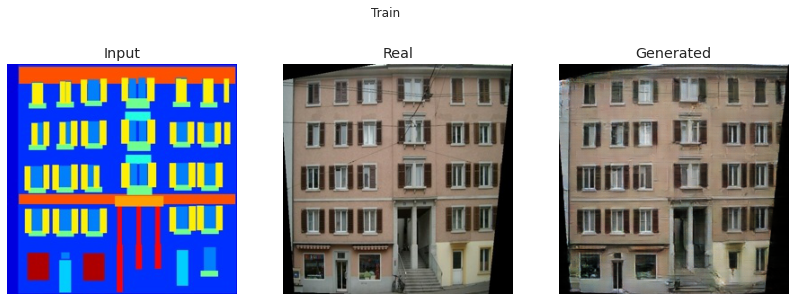

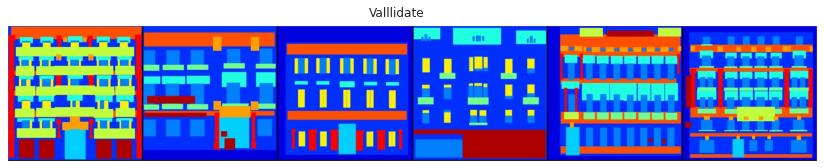

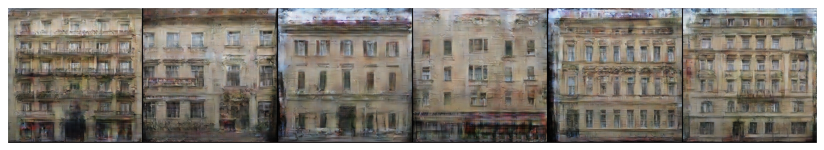

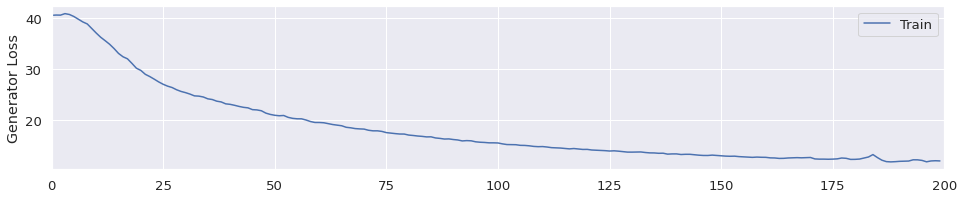

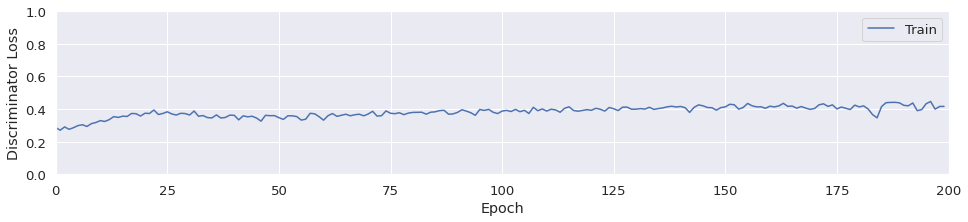

In [ ]:
info = train(pix2pix, trainloader_facade, valloader_facade)

### Сохранение модели

In [ ]:
path = '/content/drive/MyDrive/pix2pix_facades/my_p2p_model_facade.pth'

Сохранение модели

In [ ]:
torch.save({
    'model_discriminator_state_dict': pix2pix['discriminator'].state_dict(),
    'model_generator_state_dict': pix2pix['generator'].state_dict()
}, path)

Загрузка модели

In [ ]:
checkpoint = torch.load(path)

pix2pix['discriminator'].load_state_dict(checkpoint['model_discriminator_state_dict'])
pix2pix['generator'].load_state_dict(checkpoint['model_generator_state_dict'])

<All keys matched successfully>

### Проверка модели

In [ ]:
valloader = DataLoader(val_dataset, batch_size=100, shuffle=False)

In [ ]:
for plan, real_facades in tqdm(valloader_facade):
    pix2pix["generator"].eval()
    with torch.no_grad():
        fake_facades = pix2pix['generator'](plan.to(device))
        show_images(plan.cpu(), 6, figsize=(20, 4), title='Input')
        show_images(real_facades.cpu(), 6, figsize=(20, 4), title='Ground truth')
        show_images(fake_facades.cpu(), 6, figsize=(20, 4), title='Generated')

# Часть 2. Решение новой задачи 

В качестве самостоятельной задачи я выбрала задачу улучшения качества и восстановления информации сильно затемненных фото.

Датасет был найден в интернете и скачан [здесь](https://drive.google.com/file/d/1GAB3uGsmAyLgtDBDONbil08vVu5wJcG3/view).

## Загрузка и обработка датасета

In [ ]:
!unzip /content/drive/MyDrive/final_project/dark.zip
!unzip /content/drive/MyDrive/final_project/light.zip

!unzip /content/drive/MyDrive/final_project/dark_test.zip
!unzip /content/drive/MyDrive/final_project/ligh_test.zip

In [ ]:
path_dark = '/content/dark'
path_light = '/content/light'

path_test_light = '/content/ligh_test'
path_test_dark = '/content/dark_test'

In [ ]:
class LowlightDataset(Dataset):
    def __init__(self, path_d, path_l):
        self.filenames_dark = glob(str(Path(path_d) / "*"))
        self.filenames_light = glob(str(Path(path_l) / "*"))
        self.filenames_dark = sorted(self.filenames_dark,  key=lambda fname: int(re.split(r'[/\.]',fname)[3]))
        self.filenames_light = sorted(self.filenames_light,  key=lambda fname: int(re.split(r'[/\.]',fname)[3]))
    def __len__(self):
        return len(self.filenames_dark)  

    def __getitem__(self, idx):
        transform=tt.Compose([
                tt.ToTensor(),
                tt.Resize((256, 256)),
                tt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                ])

        dark = self.filenames_dark[idx]
        light = self.filenames_light[idx]
            
        dark_img = Image.open(dark)
        light_img = Image.open(light)

        dark_img = transform(dark_img)
        light_img = transform(light_img)
        return dark_img, light_img
  

In [ ]:
train_dataset = LowlightDataset(path_dark, path_light)
trainloader_light = DataLoader(train_dataset, batch_size=1, shuffle=True)

test_dataset = LowlightDataset(path_test_dark, path_test_light)
testloader_light = DataLoader(test_dataset, batch_size=8, shuffle=True)

Количество изображений для обучения:

In [ ]:
len(train_dataset)

233

Количество изображений для валидации:

In [ ]:
len(test_dataset)

8

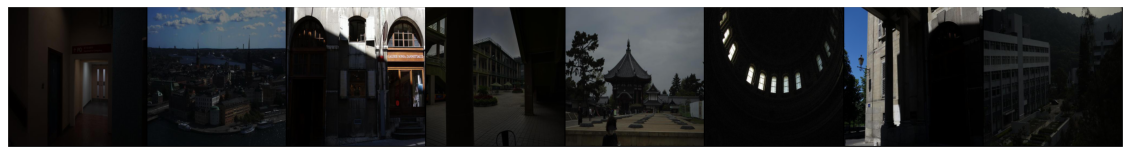

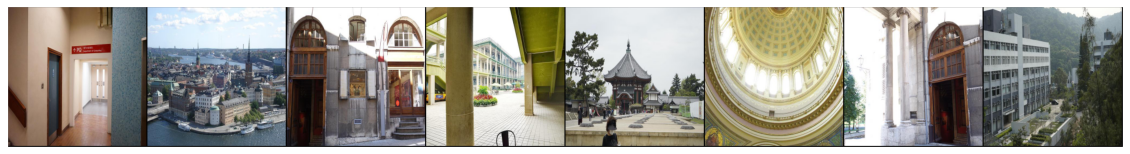

In [ ]:
show_batch(DataLoader(train_dataset, batch_size=8, shuffle=True))

In [ ]:
trainloader_light = DeviceDataLoader(trainloader_light, device)
testloader_light = DeviceDataLoader(testloader_light, device)

## Обучение

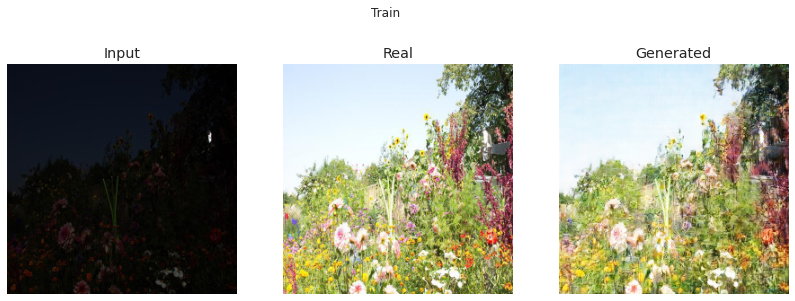

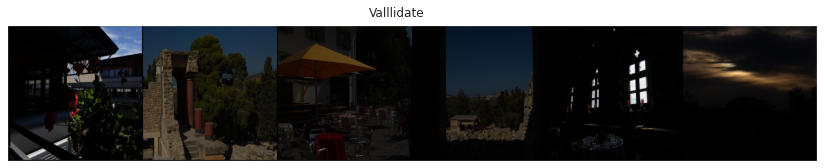

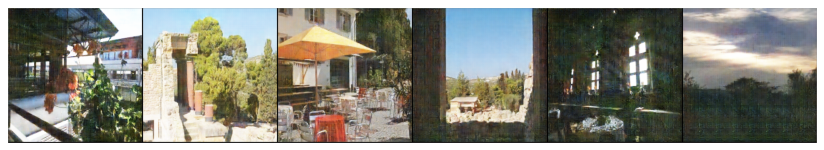

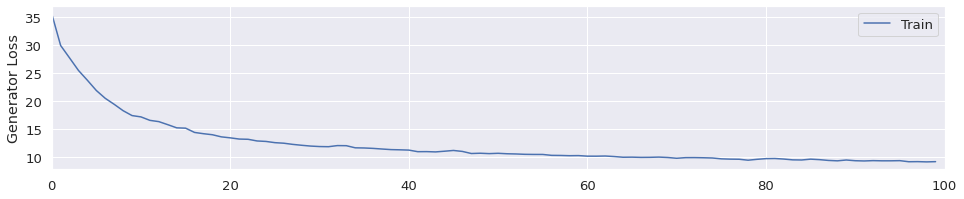

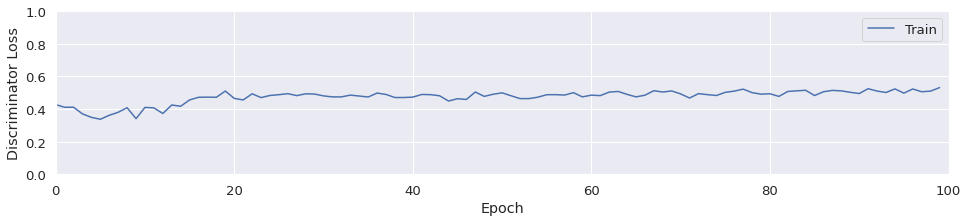

([35.65686734244547,
  29.950469901121735,
  27.719509636383712,
  25.470365716664066,
  23.709588955400328,
  21.877932646755497,
  20.474455759760648,
  19.403723720828864,
  18.260043246551646,
  17.384653513012015,
  17.148484422413578,
  16.528438394161764,
  16.300300106981794,
  15.756407962848188,
  15.189016301232858,
  15.12822490904976,
  14.363363775572552,
  14.137250595338354,
  13.95167825968992,
  13.570401564176501,
  13.394052902516377,
  13.177622809430561,
  13.13348645918359,
  12.837319290177504,
  12.751280942188313,
  12.531628819494289,
  12.43142026893059,
  12.223341370856813,
  12.061352068774179,
  11.919586723966148,
  11.834403451420206,
  11.806946678734644,
  12.005899965507279,
  11.987855491720044,
  11.607343329892139,
  11.57750237141556,
  11.504515078958011,
  11.391100605158336,
  11.287181041783018,
  11.248480258581464,
  11.198213808526297,
  10.91382255881641,
  10.925247124847935,
  10.87360628889354,
  10.998031986629503,
  11.1334143830982

In [ ]:
train(pix2pix, trainloader_light, testloader_light, epochs=100)

### Сохрание весов модели

In [ ]:
path = '/content/drive/MyDrive/final_project/my_p2p_model.pth' 

In [ ]:
torch.save({
    'model_discriminator_state_dict': pix2pix['discriminator'].state_dict(),
    'model_generator_state_dict': pix2pix['generator'].state_dict()
}, path)

### Проверка качеста на валидации

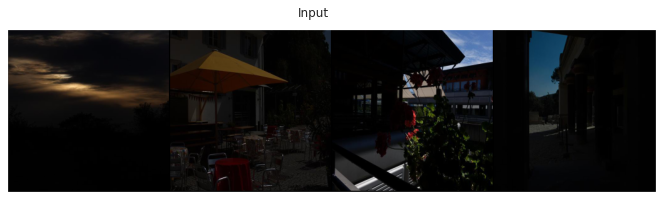

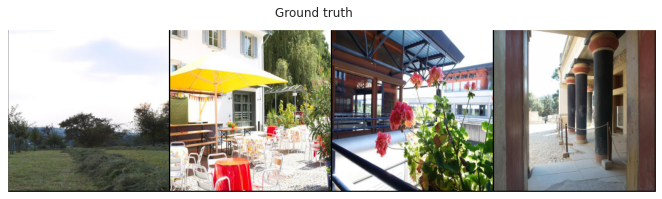

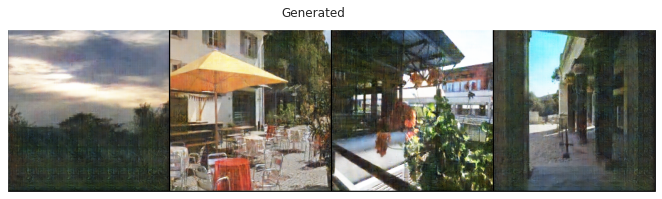

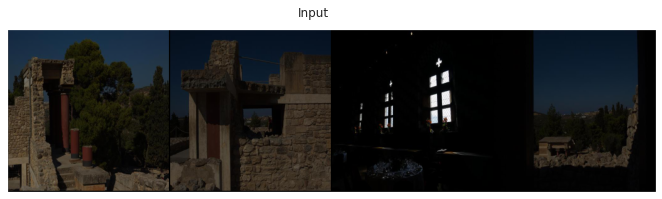

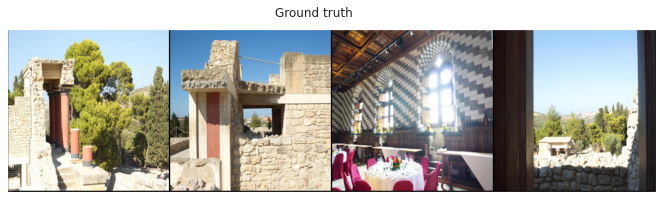

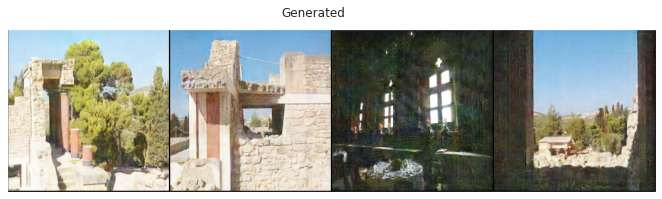

In [ ]:
for dark, light in tqdm(DataLoader(test_dataset, batch_size=4, shuffle=True)):
    pix2pix["generator"].eval()
    with torch.no_grad():
        fake_fig = pix2pix['generator'](dark.to(device))
        show_images(dark.cpu(), 6, figsize=(20, 3), title='Input')
        show_images(light.cpu(), 6, figsize=(20, 3), title='Ground truth')
        show_images(fake_fig.cpu(), 6, figsize=(20, 3), title='Generated')